In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import os
import spotipy
import requests
import json
import base64
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import date
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [4]:
# Credenciales generadas en sptify my dashboard
# https://developer.spotify.com/dashboard/applications
with open('Credenciales.json') as file:
    cred = json.load(file)['Credenciales'][0]
client_id = cred['client_id']
client_secret = cred['client_secret']

In [9]:
# Codificando a Base64 'client_id:client_secrete'
client_str = '{client_id}:{client_secret}'.format(client_id=client_id, client_secret=client_secret)
client_encode = base64.b64encode(client_str.encode("utf-8"))  # Codificado en Bytes
client_encode = str(client_encode, "utf-8")  # Codificado en String

# Generando header con token de autorizacion
token_url = 'https://accounts.spotify.com/api/token'
params = {'grant_type': 'client_credentials'}
headers = {'Authorization' : 'Basic {client_encode}'.format(client_encode=client_encode)}
r = requests.post('https://accounts.spotify.com/api/token', headers=headers, data=params)
print(r.status_code)
token = r.json()['access_token']
header = {'Authorization': f'Bearer {token}'}

# Prueba con una cancion 
url_base = 'https://api.spotify.com'
id_im = '6mdiAmATAx73kdxrNrnlao'
cancion = requests.get(url_base+f'/v1/artists/{id_im}', headers=header)
cancion.json()

200


{'external_urls': {'spotify': 'https://open.spotify.com/artist/6mdiAmATAx73kdxrNrnlao'},
 'followers': {'href': None, 'total': 6757520},
 'genres': ['hard rock', 'metal', 'nwobhm', 'rock'],
 'href': 'https://api.spotify.com/v1/artists/6mdiAmATAx73kdxrNrnlao',
 'id': '6mdiAmATAx73kdxrNrnlao',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5ebdc52c8e309e46aa8430a0fa0',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174dc52c8e309e46aa8430a0fa0',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178dc52c8e309e46aa8430a0fa0',
   'width': 160}],
 'name': 'Iron Maiden',
 'popularity': 77,
 'type': 'artist',
 'uri': 'spotify:artist:6mdiAmATAx73kdxrNrnlao'}

In [ ]:
# Generando coneccion con la libreria spotipy que es una reimplementacion de la API de Spotify
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# Cargando DataFrame con los archivos obtenidos de Spotify Charts
ruta_arch = './SpotifyChartsTop200Hist2021/'
spotify_charts_top200_2021_df = pd.DataFrame()
for arch_name in os.listdir(ruta_arch):
    df_tem = pd.read_csv(ruta_arch + arch_name, skiprows=1)
    df_tem['track_id'] = df_tem['URL'].apply(lambda url: url.split('/')[-1])
    df_tem[['date_initial','date_fin']] = arch_name.replace('regional-mx-weekly-','').replace('.csv','').split('--')
    spotify_charts_top200_2021_df = pd.concat([spotify_charts_top200_2021_df,df_tem],ignore_index=True)

In [ ]:
# Funcion para extraer informacion de las cancion y el artista pasando una lista de de tracks
# Retorna un DataFrame con la informacion extra como indice el id de la cancion
def get_inf_track(list_tracks):
    dic_data_track ={'track_id':[], 'track_name':[], 'track_release_date': [],
                    'explicit':[],'track_popularity':[],
                    'album_name':[], 'artist_id':[], 'artist_name':[],
                    'artist_followers':[], 'artist_popularity':[],  
                    'collaboration_artists_names':[] }
    for track_id in list_tracks:
        # Data track
        data_track = sp.track(track_id)
        dic_data_track['track_id'].append(track_id)
        dic_data_track['track_name'].append(data_track['name'])
        dic_data_track['track_release_date'].append(data_track['album']['release_date'])
        dic_data_track['explicit'].append(data_track['explicit'])
        dic_data_track['track_popularity'].append(data_track['popularity'])
        dic_data_track['album_name'].append(data_track['album']['name'])
        # Data Artist
        data_artist = sp.artist(data_track['artists'][0]['id'])
        dic_data_track['artist_id'].append(data_track['artists'][0]['id'])
        dic_data_track['artist_name'].append(data_track['artists'][0]['name'])
        dic_data_track['artist_followers'].append(data_artist['followers']['total'])
        dic_data_track['artist_popularity'].append(data_artist['popularity'])
        dic_data_track['collaboration_artists_names'].append((',').join([singer_name['name'] for singer_name in data_track['artists']]))
    
    data_track_df = pd.DataFrame.from_dict(dic_data_track)

    return data_track_df

In [ ]:
#Concatenando el DF original on la nueva informacion de los tracks
spotify_charts_top200_2021_df = pd.merge(spotify_charts_top200_2021_df,
                                        get_inf_track(spotify_charts_top200_2021_df['track_id'].unique()),
                                        on = 'track_id',
                                        how = 'left')
spotify_charts_top200_2021_df = spotify_charts_top200_2021_df.rename(columns={'Track Name' : 'Track_Name_Orig'})


In [ ]:
#Guardando los datos en un csv para no generar la consulta nuevamente 
spotify_charts_top200_2021_df.to_csv('spotify_charts_top200_2021_df.csv')

In [ ]:
# Para cargar el Dataframe
spotify_charts_top200_2021_df = pd.read_csv('spotify_charts_top200_2021_df.csv')

In [ ]:
# Cambiando el tipo de dato a datetime
spotify_charts_top200_2021_df['track_release_date'] = pd.to_datetime(spotify_charts_top200_2021_df['track_release_date'], format='%Y-%m-%d')
spotify_charts_top200_2021_df['date_initial'] = pd.to_datetime(spotify_charts_top200_2021_df['date_initial'], format='%Y-%m-%d')
spotify_charts_top200_2021_df['date_fin'] = pd.to_datetime(spotify_charts_top200_2021_df['date_fin'], format='%Y-%m-%d')
spotify_charts_top200_2021_df = spotify_charts_top200_2021_df.sort_values('date_initial')
# Filtrando las canciones del 2021
spotify_charts_top200_2021_df = spotify_charts_top200_2021_df[spotify_charts_top200_2021_df['track_release_date'] >= '2021-01-01']
# Quitando las lineas que no traen informacion 
spotify_charts_top200_2021_df = spotify_charts_top200_2021_df[spotify_charts_top200_2021_df['artist_popularity'] != 0]

In [ ]:
# Generando plot para la segmentacion de cuadrantes
fig = px.scatter(x = spotify_charts_top200_2021_df['artist_popularity'],
                y = spotify_charts_top200_2021_df['track_popularity'],
                color = spotify_charts_top200_2021_df['artist_followers'])
fig.add_vline(spotify_charts_top200_2021_df['artist_popularity'].mean())
fig.add_hline(spotify_charts_top200_2021_df['track_popularity'].mean())
fig.show()

In [ ]:
# Funcion para obtener los cuadrantes superiores
def fun_cuadrantes(df,tipo):
    if tipo == 'amp_cp': #Artista con menos popularidad y cancion popular
        df = df[(df.artist_popularity < df.artist_popularity.mean()) & 
            (df.track_popularity > df.track_popularity.mean())]
    elif tipo == 'ap_cp': #Artista popular y cancion popular
        df = df[(df.artist_popularity > df.artist_popularity.mean()) & 
            (df.track_popularity > df.track_popularity.mean())]
    return df

In [ ]:
# Generando data de los cuarteles 
amp_cp = fun_cuadrantes(spotify_charts_top200_2021_df,'amp_cp')
ap_cp = fun_cuadrantes(spotify_charts_top200_2021_df,'ap_cp')

In [ ]:
# Agrupando para informacion por artista
amp_cp_artist = amp_cp.groupby(['date_initial', 'artist_id', 'artist_name'])[['Streams']].sum().reset_index()

In [ ]:
# Ploteando la tendencia de los artistas
fig = px.line(amp_cp_artist, x="date_initial", y="Streams", color='artist_name')
fig.add_vline(date(2021,3,31))
fig.add_vline(date(2021,6,30))
fig.show()

In [ ]:
#['TINI', 'Marc Seguí', 'LAGOS', 'Tiago PZK', 'Ingratax', 'Oliver Tree', 'LISA', 'Matisse']

In [ ]:
# Generando Df de tendencias
dic_art_ten = {'artist_id':[], 'streams_min':[], 'streams_med':[], 'streams_max':[]}

for art_id in amp_cp_artist['artist_id'].unique():
    df_tem = amp_cp_artist[amp_cp_artist['artist_id'] == art_id]
    dic_art_ten['artist_id'].append(art_id)
    streams_min = int(df_tem[df_tem['date_initial'] == min(df_tem['date_initial'])]['Streams']) # Valor inicial por fecha
    dic_art_ten['streams_min'].append(streams_min)
    tot_mean = int(round(len(df_tem['date_initial'])/2,0))
    streams_med = int(df_tem[df_tem['date_initial'] == list(df_tem['date_initial'])[tot_mean]]['Streams']) # Valor intermedio
    dic_art_ten['streams_med'].append(streams_med)
    streams_max = int(df_tem[df_tem['date_initial'] == max(df_tem['date_initial'])]['Streams']) # Ultimo valor registrado
    dic_art_ten['streams_max'].append(streams_max)

art_ten_df = pd.DataFrame(dic_art_ten)
# Obteniendo artistas con tendencia
art_ten_df['Tend'] =  (art_ten_df['streams_min'] < art_ten_df['streams_med']) & (art_ten_df['streams_med'] < art_ten_df['streams_max'])


In [ ]:
#Filtrando artistas con tendencias
amp_cp_artist = pd.merge(amp_cp_artist,
                        art_ten_df[['artist_id','Tend']],
                        on = 'artist_id',
                        how = 'left')
amp_cp_artist = amp_cp_artist[amp_cp_artist['Tend'] == True]

In [ ]:
data = amp_cp[(amp_cp['artist_id'] =='44mEtidu0VdRkIqO4IbkNa') |
            (amp_cp['artist_id'] =='4jogXSSvlyMkODGSZ2wc2P')].groupby([
                'artist_name', 'artist_popularity', 'track_name', 'track_popularity'
            ]).agg({'Position':min, 'Streams':max}).reset_index()
data

,artist_name,artist_popularity,track_name,track_popularity,Position,Streams
0,Calibre 50,82,A La Antigüita,84,1,4732116
1,Calibre 50,82,Cuidando El Territorio,79,15,2509664
2,Marca MP,78,Ya Acabo,83,9,3101684


In [ ]:
# Ploteando artistas con tendencia
fig = px.line(amp_cp_artist, x="date_initial", y="Streams", color='artist_name')
fig.add_vline(date(2021,3,31))
fig.add_vline(date(2021,6,30))
fig.show()

In [ ]:
# Generando DF de tendencias con artistas populares
ap_cp = fun_cuadrantes(spotify_charts_top200_2021_df,'ap_cp')
ap_cp_artist = ap_cp.groupby(['date_initial', 'artist_id', 'artist_name'])[['Streams']].sum().reset_index()

dic_art_ten_ap_cp = {'artist_id':[], 'streams_min':[], 'streams_med':[], 'streams_max':[]}

for art_id in ap_cp_artist['artist_id'].unique():
    df_tem = ap_cp_artist[ap_cp_artist['artist_id'] == art_id]
    dic_art_ten_ap_cp['artist_id'].append(art_id)
    streams_min = int(df_tem[df_tem['date_initial'] == min(df_tem['date_initial'])]['Streams'])
    dic_art_ten_ap_cp['streams_min'].append(streams_min)
    tot_mean = int(round(len(df_tem['date_initial'])/2,0))
    streams_med = int(df_tem[df_tem['date_initial'] == list(df_tem['date_initial'])[tot_mean]]['Streams'])
    dic_art_ten_ap_cp['streams_med'].append(streams_med)
    streams_max = int(df_tem[df_tem['date_initial'] == max(df_tem['date_initial'])]['Streams'])
    dic_art_ten_ap_cp['streams_max'].append(streams_max)

art_ten_ap_cp_df = pd.DataFrame(dic_art_ten_ap_cp)
art_ten_ap_cp_df['Tend'] =  (art_ten_ap_cp_df['streams_min'] < art_ten_ap_cp_df['streams_med']) & (art_ten_ap_cp_df['streams_med'] < art_ten_ap_cp_df['streams_max'])

ap_cp_artist = pd.merge(ap_cp_artist,
                        art_ten_ap_cp_df[['artist_id','Tend']],
                        on = 'artist_id',
                        how = 'left')
ap_cp_artist = ap_cp_artist[ap_cp_artist['Tend'] == True]

fig = px.line(ap_cp_artist, x="date_initial", y="Streams", color='artist_name')
fig.add_vline(date(2021,3,31))
fig.add_vline(date(2021,6,30))
fig.show()

In [ ]:
# Quitando Raw Alejandro
ap_cp_artist = ap_cp_artist[ap_cp_artist['artist_id'] != '1mcTU81TzQhprhouKaTkpq'] 

In [ ]:
# Juntando los artistas prometedores con los artistas populares
top_artist_id = list(ap_cp_artist['artist_id'].unique()) + list(amp_cp_artist['artist_id'].unique())
top_artist_df = pd.DataFrame()
for art_id_p in top_artist_id:
    df_temp = spotify_charts_top200_2021_df[spotify_charts_top200_2021_df['artist_id'] == art_id_p]
    df_temp = df_temp.groupby(['artist_id','artist_name','artist_popularity','artist_followers',
                                'track_id','track_name','track_popularity','explicit']).agg({
                                    'Streams':sum,'Position':min}).reset_index()
    top_artist_df = pd.concat([top_artist_df,df_temp],ignore_index=True)

# Obteniendo los Features de las canciones 
features = sp.audio_features(top_artist_df['track_id'])
features_df = pd.DataFrame.from_dict(features).rename(columns={'id': 'track_id'})
features_df['duration_min']=features_df['duration_ms']/60000

# Uniondo Features de las canciones
top_artist_features_df = pd.merge(top_artist_df,
                                features_df,
                                on = 'track_id',
                                how = 'left')

In [ ]:
# Transformando valores y estandarizando 
colums = ['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_min']

columns_z = [] # Lista de columnas trandormadas
for colum in colums:
    scaler = StandardScaler().fit(top_artist_features_df[[colum]]) 
    name_colum_z = colum + '_Z'
    top_artist_features_df[name_colum_z] = scaler.transform(top_artist_features_df[[colum]]) # creacion de una nueva columna con las variables estandarizadas
    columns_z.append(name_colum_z)

In [ ]:
X_train, X_test = train_test_split(top_artist_features_df[columns_z], random_state = 10)
print('Length of training set: ' + str(len(X_train)))
print('Length of test set: ' + str(len(X_test)))
print('Length of all set: ' + str(len(top_artist_features_df)))

Length of training set: 20
Length of test set: 7
Length of all set: 27


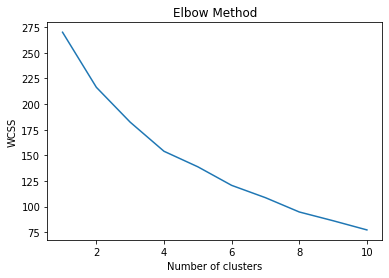

In [ ]:
# Buscando la mejor divicion para el algoritmo de Kmeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=10)
    kmeans.fit(top_artist_features_df[columns_z])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

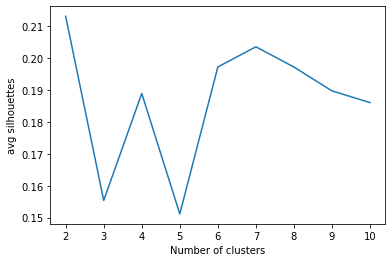

In [ ]:
# Buscando cual es el mejor numero de k que se adapten bien ala silueta de las agrupaciones
avg_silhouettes = []
krange = list(range(2,11))
x = top_artist_features_df[columns_z].values
for n in krange:
    kmeans = KMeans(n_clusters=n, random_state=10)
    clusster_assignments = kmeans.fit_predict(x)
    silh_avg = metrics.silhouette_score(x,clusster_assignments)
    avg_silhouettes.append(silh_avg)
plt.plot(krange, avg_silhouettes)
plt.xlabel('Number of clusters')
plt.ylabel('avg silhouettes')
plt.show()

In [ ]:
n_cluster = 2 #numero de cluster asignados por el metodo del codo
model = KMeans(n_clusters=n_cluster, random_state=10)
model.fit(X_train)
km_labels = model.predict(X_test)
km_silhouette = metrics.silhouette_score(X_test, km_labels)
print('k-means silhouette score: ' + str(km_silhouette))

k-means silhouette score: 0.24179742820384437


In [ ]:
# Generando Clusters
model = KMeans( n_clusters = 2,
                random_state = 10)
model.fit(top_artist_features_df[columns_z])
top_artist_features_df['Cluster'] = model.labels_
top_artist_features_df.head()

,artist_id,artist_name,artist_popularity,artist_followers,track_id,track_name,track_popularity,explicit,Streams,Position,...,energy_Z,loudness_Z,speechiness_Z,acousticness_Z,instrumentalness_Z,liveness_Z,valence_Z,tempo_Z,duration_min_Z,Cluster
0,790FomKkXshlbRYZFtlgla,KAROL G,88,18932857,0MT6qJd7wKlWjH7tP7oWHi,EL BARCO,74,False,2490600,179,...,1.356721,0.997766,-0.790174,1.565583,-0.159481,0.961418,1.241740,0.495573,0.042302,1
1,790FomKkXshlbRYZFtlgla,KAROL G,88,18932857,0aZnyTWJNgdzYoOiaW8HKG,200 COPAS,78,False,12692116,47,...,0.248992,-0.404771,1.406502,2.329442,-0.431035,1.527016,1.051555,-1.160505,0.502382,0
2,790FomKkXshlbRYZFtlgla,KAROL G,88,18932857,0dKg2vGC1hFqcK5LGTaKzX,Tusa,70,False,22290720,50,...,0.226073,1.124567,2.435137,0.086832,-0.327479,-0.864278,-0.459061,-0.855854,-0.010970,1
3,790FomKkXshlbRYZFtlgla,KAROL G,88,18932857,1WvrDdouh6C51In1SdATbq,BICHOTA,72,True,50364132,4,...,-0.102426,0.480513,0.702700,-0.427304,0.449758,-0.511766,0.942877,1.122056,-0.790650,1
4,790FomKkXshlbRYZFtlgla,KAROL G,88,18932857,1beTDCe7sT7fzm8WIKXicz,"Ay, DiOs Mío!",65,False,11586260,66,...,0.279550,0.256293,1.189948,1.075930,0.990052,-0.505189,-0.942676,1.627055,-0.430803,1


In [ ]:
# Ploteando Clusters de artistas
pca = PCA(n_components = 2)
top_artist_features_df['PC1'], top_artist_features_df['PC2'] = zip(* pca.fit_transform(top_artist_features_df[columns_z]))

fig = px.scatter(x = top_artist_features_df['PC1'],
                y = top_artist_features_df['PC2'],
                symbol = top_artist_features_df['Cluster'],
                color = top_artist_features_df['Cluster'])
fig.show()

In [ ]:
# Top Streams de cluster1
top_artist_features_df_c0 = top_artist_features_df[top_artist_features_df['Cluster'] == 0]
top_artist_features_df_c0.groupby(['artist_name','track_name'])[['Streams']].sum().reset_index().sort_values('Streams', ascending = False)

,artist_name,track_name,Streams
5,Marca MP,Ya Acabo,53165352
2,Grupo Firme,En Tu Perra Vida,19980183
3,Grupo Firme,Ya Supérame (En Vivo),15445908
4,KAROL G,200 COPAS,12692116
1,Doja Cat,Need To Know,7548096
0,Calibre 50,Te Volvería A Elegir,5949952


/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



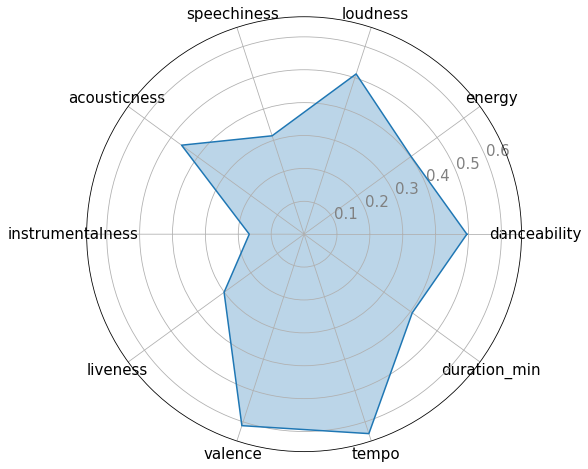

In [ ]:
# Genrando plot de con los estilo de musica del primer cluster
colums = ['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_min']

tracks_features = top_artist_features_df_c0[colums]
min_max_scaler = MinMaxScaler()
tracks_features.loc[:]=min_max_scaler.fit_transform(tracks_features.loc[:])

fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(tracks_features.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value=list(tracks_features.mean())

# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
# calculate angle for each category
angles=[n/float(N)*2*3.141625 for n in range(N)]
angles+=angles[:1]

# plot
plt.polar(angles, value)
plt.fill(angles,value,alpha=0.3)


plt.xticks(angles[:-1],categories, size=15)
plt.yticks(color='grey',size=15)
plt.show()

In [ ]:
# Top Streams de cluster2
top_artist_features_df_c1 = top_artist_features_df[top_artist_features_df['Cluster'] == 1]
top_artist_features_df_c1.groupby(['artist_name','track_name'])[['Streams']].sum().reset_index().sort_values('Streams', ascending = False)

,artist_name,track_name,Streams
12,KAROL G,EL MAKINON,56273986
10,KAROL G,BICHOTA,50364132
0,Calibre 50,A La Antigüita,37581792
2,Doja Cat,Kiss Me More (feat. SZA),36767547
18,Maluma,Sobrio,34816353
13,KAROL G,LOCATION,29245792
15,KAROL G,Tusa,22290720
16,Maluma,Agua de Jamaica,21168538
1,Calibre 50,Cuidando El Territorio,19277892
9,KAROL G,"Ay, DiOs Mío!",11586260


/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



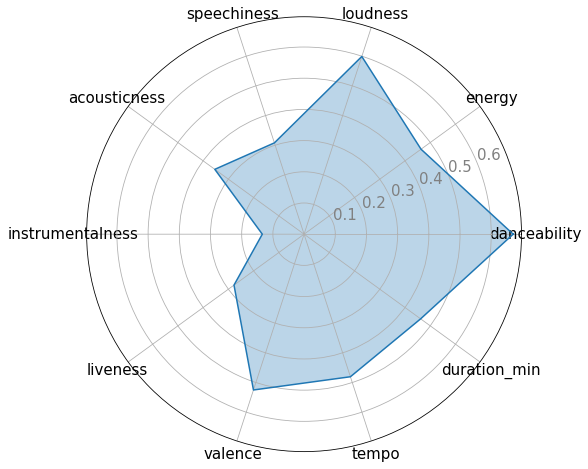

In [ ]:
# Genrando plot de con los estilo de musica del segundo cluster
colums = ['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_min']

tracks_features = top_artist_features_df_c1[colums]
min_max_scaler = MinMaxScaler()
tracks_features.loc[:]=min_max_scaler.fit_transform(tracks_features.loc[:])

fig=plt.figure(figsize=(12,8))

# convert column names into a list
categories=list(tracks_features.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value=list(tracks_features.mean())

# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
# calculate angle for each category
angles=[n/float(N)*2*3.141625 for n in range(N)]
angles+=angles[:1]

# plot
plt.polar(angles, value)
plt.fill(angles,value,alpha=0.3)


plt.xticks(angles[:-1],categories, size=15)
plt.yticks(color='grey',size=15)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=95703bae-4b41-4438-b59e-219bfa3b7412' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>